In [2]:
%load_ext autoreload
%autoreload 2

import numpy as np
import os

from collections import deque
import matplotlib.pyplot as plt
from IPython.display import Image

from unityagents import UnityEnvironment

from ccontrol.agent import DDPG_agent
from ccontrol.config import DDPG_configuration
from ccontrol.utils import Context, to_np, Runner, plot_scores, load_scores, load_agent

In [3]:
path_images = r'../image'

__________
### Description of the environment


This Unity environment consist of a **double-jointed arm** that can move in a three dimensional space and a spherical target location. The goal of the agents is to **move its hand to the goal location**, and keep it there as it get a +0.1 **reward** for each step it’s hand is in goal location.

The simulation can contain up to 20 agents that share the same behavior parameters. At each time step, each agent must return **action vector** $\in [0,1]^4$ corresponding to torque that will be applied to the two joints.

They observe 33-dimensional **state space** corresponding to position, rotation, velocity, and angular velocities of the two arms.

Environment for one agent : 



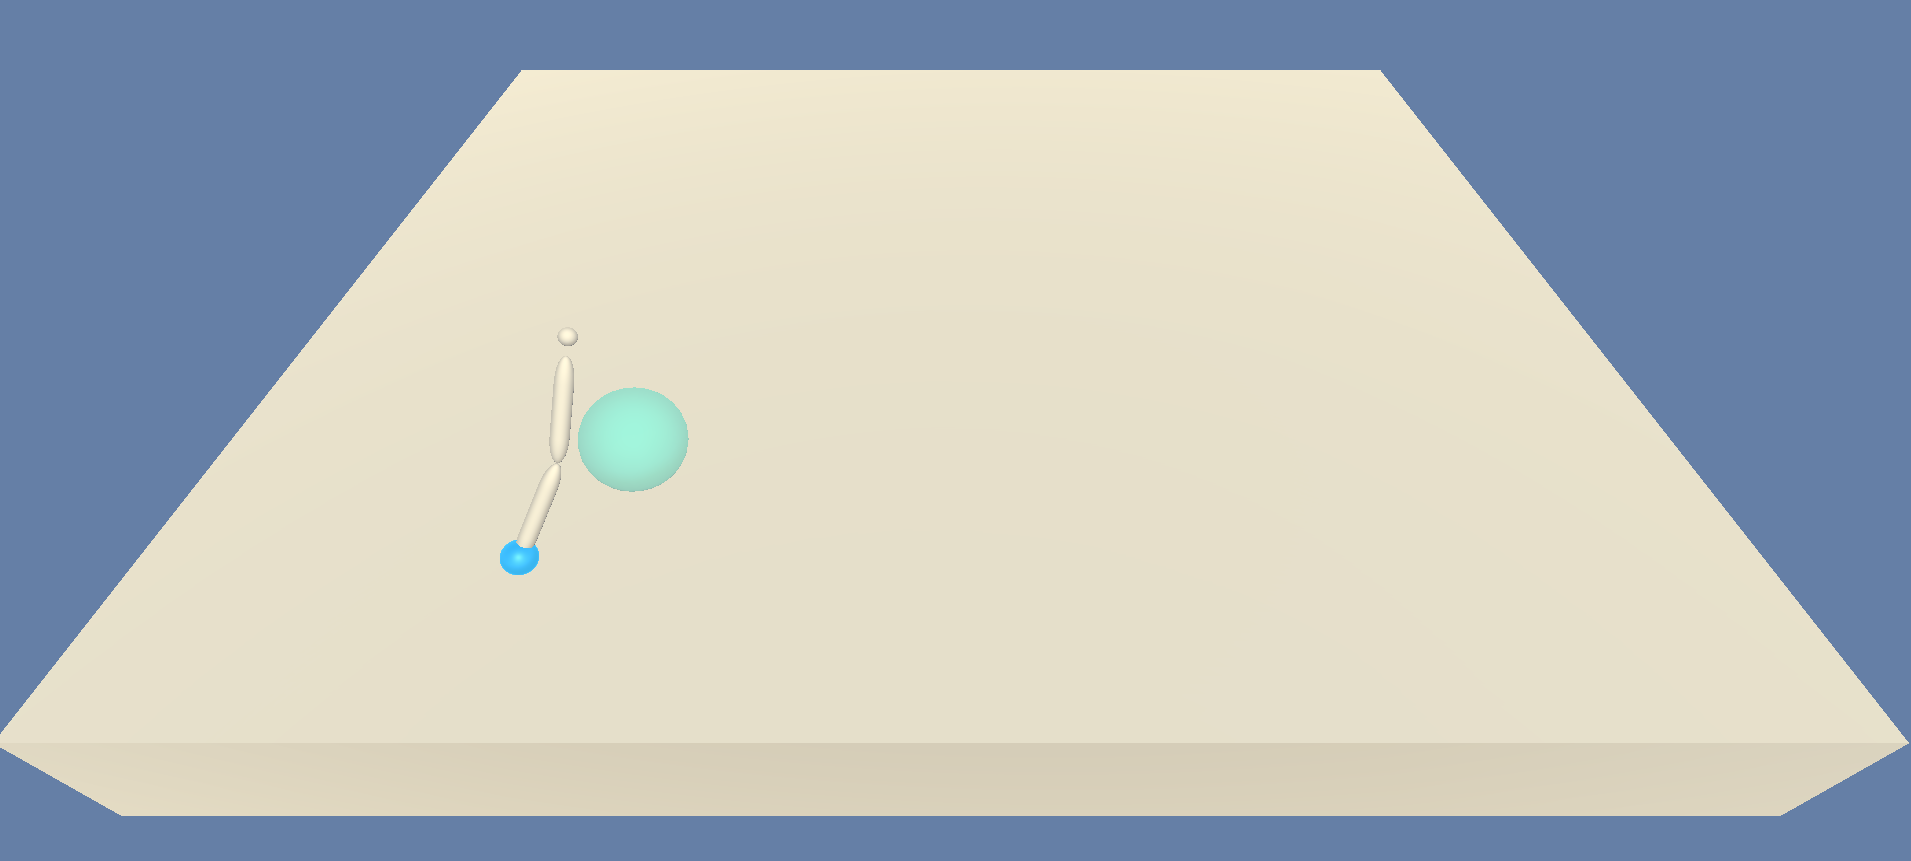

In [3]:
print('Environment for one agent : \n')
Image(os.path.join(path_images, 'environment_1_agent.png'), width = 600, height = 400) 

### Training a single agent

#### Start the environment

In [4]:
TARGET_SCORE = 30
env_file_name = \
    r'../../Unity_environments/Reacher_Windows_x86_64_1_Agent/Reacher_Windows_x86_64/Reacher.exe'

env = UnityEnvironment(env_file_name)

brain_name = env.brain_names[0]
brain = env.brains[brain_name]
env_info = env.reset(train_mode=True)[brain_name]
num_agents = len(env_info.agents)

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


In [5]:
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

action_size = brain.vector_action_space_size
print('\nSize of each action:', action_size)

states = env_info.vector_observations
state_size = states.shape[1]
print('\nThere are {} agents. Each observes a state with length: {}\n'
          .format(states.shape[0], state_size))
print('The state for the first agent looks like:\n', states[0])

Number of agents: 1

Size of each action: 4

There are 1 agents. Each observes a state with length: 33

The state for the first agent looks like:
 [ 0.00000000e+00 -4.00000000e+00  0.00000000e+00  1.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -1.00000000e+01  0.00000000e+00
  1.00000000e+00 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  5.75471878e+00 -1.00000000e+00
  5.55726671e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
 -1.68164849e-01]


#### Training

In [6]:
runner = Runner()

In [7]:
# instantiate the ddpg configuration that performed the most.
# "BN" means to add batch normalization to the networks.
cfg = DDPG_configuration(
    seed=2,
    update_every=5,
    gamma=.97,
    tau=5e-4,
    actor_config={
        'architecture': 'BN'
    },
    critic_config={
        'architecture': 'BN',
        'learning_rate': 2e-4
    }
)
ctx = Context(brain, {'action_min': -1,  'action_max': 1})

agent = DDPG_agent(ctx, cfg)
print(cfg)

 *** BASE ***
 device : cpu
 gamma : 0.97
 tau : 0.0005
 batch_size : 64
 update every : 5
 *** BUFFER ***
buffer_size : 10000
buffer_type : uniform
 *** ACTOR ***
learning rate : 0.0001
architecture : BN
  *** CRITIC  ***
learning rate : 0.0002        
architecture : BN
  *** NOISE  ***
method : OU
 


#### One episode

In [8]:
%%time

env_info = env.reset(train_mode=True)[brain_name] 
state = env_info.vector_observations[0]           
score = 0  

while True:
    
    action = agent.act(state, noise=True)
    
    env_info = env.step(action)[brain_name]
    next_state = env_info.vector_observations[0]
    reward = env_info.rewards[0]
    done = env_info.local_done[0]
    
    agent.step(state, action, reward, next_state, done)
    
    state = next_state
    score += reward
    if done:
        break

print("Score: {}".format(score))

Score: 0.1599999964237213
Wall time: 3.56 s


#### Training the agent over many episodes

In [9]:
%%time

key_1A = 's2_g97_tau5m4_clr2m4'
nb_episodes = 500

runner.run(agent, env, brain_name, nb_episodes, key_1A, target_score=30,
               save_score=True, save_config=True, save_weights=True)

Episode 499 Score: 31.268999301083387 -> Solved in 301 episodes
Last score: 31.269  -> Solved in 301 episodes
 ... saving score ...
... saving actor ...
... saving critic ...
Wall time: 30min 21s


display performances

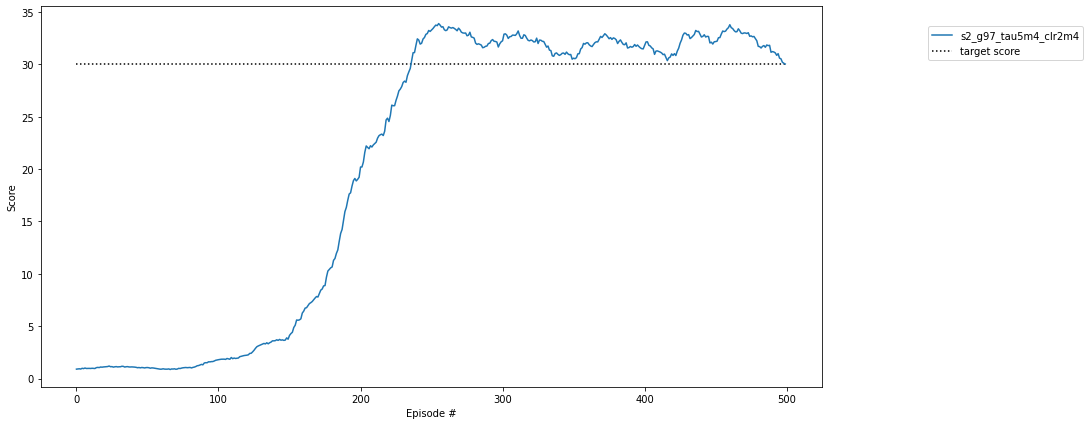

In [15]:
dict_scores = load_scores(key=key_1A)
plot_scores(dict_scores, target_score=TARGET_SCORE)

#### Load a trained agent and watch it interact for one episode

In [18]:
agent = load_agent(key_1A, agent)

env_info = env.reset(train_mode=True)[brain_name] 
state = env_info.vector_observations[0]           
score = 0  

while True:
    
    action = agent.act(state, noise=False)
    
    env_info = env.step(action)[brain_name]
    next_state = env_info.vector_observations[0]
    reward = env_info.rewards[0]
    done = env_info.local_done[0]
    
    agent.step(state, action, reward, next_state, done)
    
    state = next_state
    score += reward
    if done:
        break

print("Score: {}".format(score))

Score: 35.34999920986593


In [19]:
env.close()

### Training 20 agents simultaneously

In this setting there is a single learned set of parameters for 20 acting agents. All acting agents collect independent experiences as learning tuples that are then used to update the shared beahavior parameters.

#### Start the environment

In [6]:
TARGET_SCORE = 30
env_file_name = \
    r'../../Unity_environments/Reacher_Windows_x86_64_20_Agent/Reacher_Windows_x86_64/Reacher.exe'

env = UnityEnvironment(env_file_name)

brain_name = env.brain_names[0]
brain = env.brains[brain_name]
env_info = env.reset(train_mode=True)[brain_name]
num_agents = len(env_info.agents)

num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Number of agents: 20


Environment for twenty agents : 



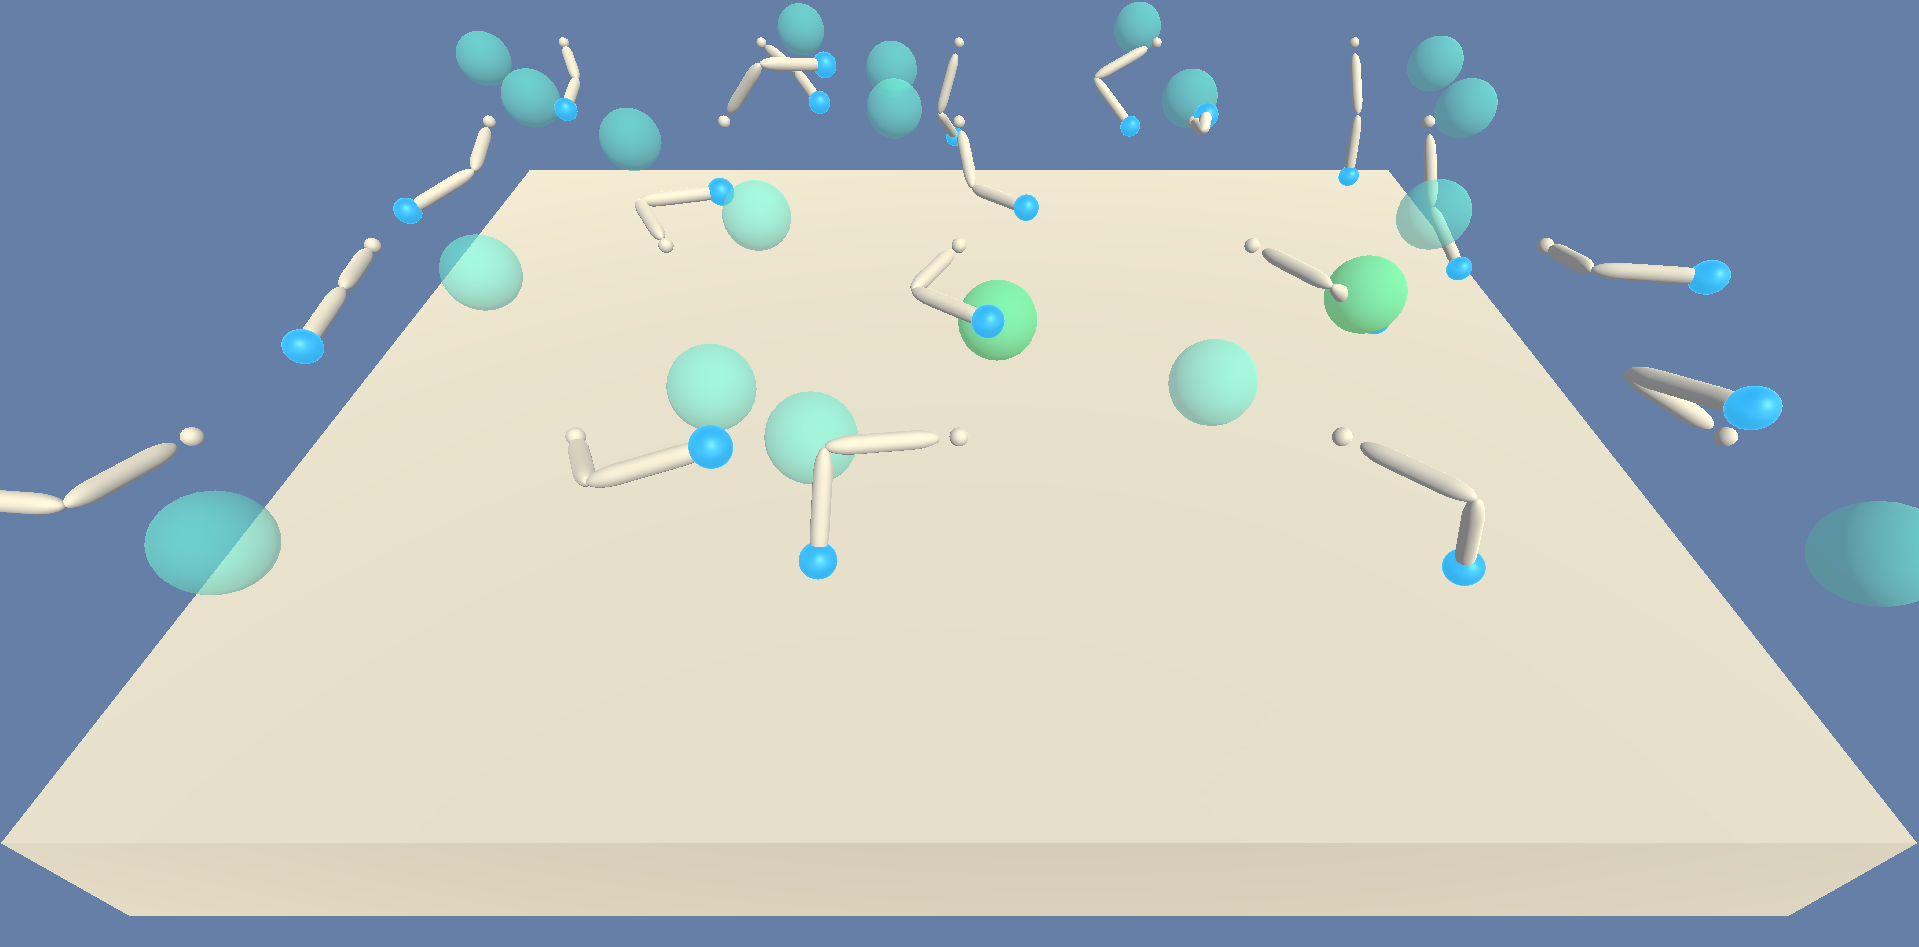

In [4]:
print('Environment for twenty agents : \n')
Image(os.path.join(path_images, 'environment_20_agents.png'), width = 600, height = 400) 

#### Training

In [4]:
runner = Runner()

In [7]:
# instantiate the ddpg configuration that performed the most for twenty agents.
# "BN" means to add batch normalization to the networks.

cfg = DDPG_configuration(
    seed=2,
    batch_size=32,
    update_every=4,
    gamma=.97,
    tau=5e-4,
    actor_config={'architecture': 'BN'},
    critic_config={
        'architecture': 'BN',
        'learning_rate': 2e-4
    }
)
ctx = Context(brain, {'action_min': -1,  'action_max': 1})

agent = DDPG_agent(ctx, cfg)
print(cfg)

 *** BASE ***
 device : cpu
 gamma : 0.97
 tau : 0.0005
 batch_size : 32
 update every : 4
 *** BUFFER ***
buffer_size : 10000
buffer_type : uniform
 *** ACTOR ***
learning rate : 0.0001
architecture : BN
  *** CRITIC  ***
learning rate : 0.0002        
architecture : BN
  *** NOISE  ***
method : OU
 


#### One episode

In [8]:
%%time

env_info = env.reset(train_mode=True)[brain_name] 
states = env_info.vector_observations          
score = 0  

while True:
    
    actions = agent.act(states, noise=True)
    
    env_info = env.step(actions)[brain_name]
    next_states = env_info.vector_observations
    rewards = env_info.rewards
    dones = env_info.local_done
    
    for state, action, reward, next_state, done in zip(states, actions, rewards, next_states, dones):
        agent.step(state, action, reward, next_state, done)
    
    states = next_states
    score += np.mean(rewards)
    if np.any(dones):
        break
        
print("Score: {}".format(score))

Score: 0.926499979291115
Wall time: 38.2 s


#### Training the agents over many episodes

In [8]:
key_20A = 's2_20A_bs32_ue4_g97_tau5m4_clr2m4'
nb_episodes = 150

runner.run(agent, env, brain_name, nb_episodes, key_20A, target_score=30,
           save_score=True, save_config=True, save_weights=True)

Episode 150 Score: 32.526999272964964 -> Solved in 111 episodes
Last score: 32.527  -> Solved in 111 episodes
 ... saving score ...
... saving actor ...
... saving critic ...


display performances

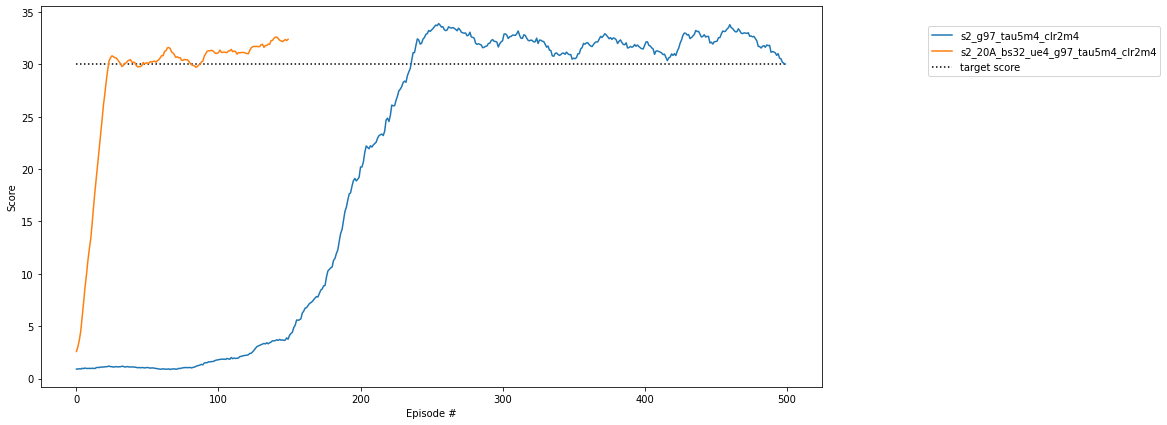

In [14]:
dict_scores = load_scores()
dict_scores_selected = {k:v for k,v in dict_scores.items() if ((k==key_1A)|(k==key_20A))}
plot_scores(dict_scores_selected, target_score=TARGET_SCORE)

#### Load a trained agent and watch it interact for one episode

In [15]:
%%time

agent = load_agent(key_20A, agent)

env_info = env.reset(train_mode=True)[brain_name] 
states = env_info.vector_observations          
score = 0  

while True:
    
    actions = agent.act(states, noise=False)
    
    env_info = env.step(actions)[brain_name]
    next_states = env_info.vector_observations
    rewards = env_info.rewards
    dones = env_info.local_done
    
    for state, action, reward, next_state, done in zip(states, actions, rewards, next_states, dones):
        agent.step(state, action, reward, next_state, done)
    
    states = next_states
    score += np.mean(rewards)
    if np.any(dones):
        break

print("Score: {}".format(score))

Score: 38.74299913402659
Wall time: 32.8 s
